In [512]:
import pandas as pd
from lifelines import KaplanMeierFitter
from scipy.stats import bernoulli
import numpy as np
import matplotlib.pyplot as plt

In [513]:
def invlogit(x):
    return np.exp(x) / (1 + np.exp(x))

def scale_x(x, k, x0, y0):
    return k*(x-x0) + np.log(y0/(1-y0)) 

def scale_map(x_pia, A, k, x0, y0):
    x_pia_belief = scale_x(x_pia, k, x0, y0)
    return -A*2*(invlogit(x_pia_belief)-0.5)  

x0 = 0.5; y0 = 0.5; k = 10

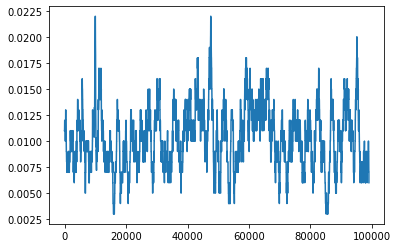

In [514]:
N = 100000
WIN = 1000

r = bernoulli.rvs(0.01, size=N)
x = np.convolve(r, np.ones(WIN)/WIN, mode='valid') 

t = np.array(range(len(x)))
x = x + 0.01*np.exp(-((t-10000)/200)**2)

fig, ax = plt.subplots(1, 1)
ax.plot(x, label='bernoulli pmf')

In [515]:
data = {'value': r}

km = pd.DataFrame(data)
a = km['value'].shift().eq(0)
b = a.cumsum()
km['new'] = b.sub(b.mask(a).ffill().fillna(0)).astype(int)
df = km.loc[km['value'].values == 1]
df = df.assign(grp = 1)

In [516]:
kmf = KaplanMeierFitter()
kmf.fit(df['new'], event_observed = df['value'])

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 1029 total observations, 0 right-censored observations>

In [517]:
p = kmf.predict(df['new'].values)
deltas = scale_map(p, 0.1, k, x0, y0)
df = df.assign(deltas = np.array(deltas))
df = df.assign(exp_deltas = np.exp(df['deltas'].values))

In [518]:
BASE_BLOCK_SIZE = 10
s = BASE_BLOCK_SIZE*np.ones(len(df))

for k in range(1,len(s)):
    s[k] = s[k-1]*df['exp_deltas'].values[k]
    
df = df.assign(block_size = s)  
df.reset_index(inplace=True)

In [519]:
ind = pd.DataFrame({'index': np.array(range(N))})
block_sizes = ind.merge(df, on='index', how='left')
block_sizes.drop(columns=['value', 'grp', 'deltas', 'exp_deltas'], inplace = True)
block_sizes.loc[0, 'block_size'] = 10
block_sizes.loc[0, 'new'] = 1
block_sizes = block_sizes.fillna(method='ffill')

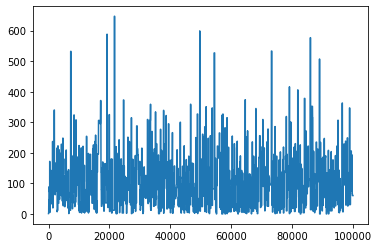

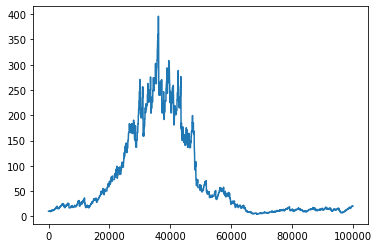

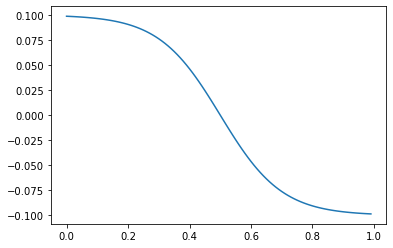

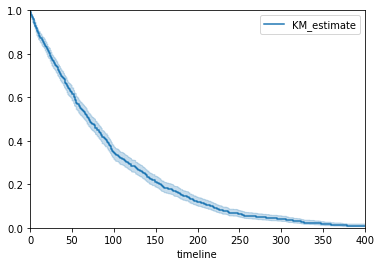

In [520]:
x0 = 0.5; y0 = 0.5; k = 10
x_pia = np.arange(0,1,0.01)

fig, ax = plt.subplots(1, 1)
ax.plot(block_sizes['new'].values, label='deltas')

fig, ax = plt.subplots(1, 1)
ax.plot(block_sizes['block_size'].values, label='deltas')

fig, ax = plt.subplots(1, 1)
ax.plot(x_pia, scale_map(x_pia, 0.1, k, x0, y0))

fig, ax = plt.subplots(1, 1)
ax = kmf.plot(xlim=(0, 400), ylim=(0, 1))